This document describes an attempt to solve for the gains of the first two inner loops of this block diagram to ensure that at a pair of the poles in each sequential loop closure end up with the desired damping ratio.

![](http://moorepants.github.io/dissertation/_images/inner-loops.png)

where

$$G_{nm}(s) = \frac{\omega_{nm}^2}{s^2 + 2\zeta_{nm}\omega_{nm}s + \omega_{nm}^2}$$

and the bicycle block is the linearized Whipple model as presented in Meijaard 2007.

# Setup

In [1]:
import os
import re

In [2]:
from IPython.display import display, Math
from sympy import MatrixSymbol, Eq, simplify, Poly, det, latex, S, solve, cse, octave_code, lambdify, ordered
import numpy as np
from scipy.optimize import fsolve
from dtk import bicycle

The `roll_rate_loop.py` file builds the bicycle state space, the neuromuscular state space, and finally the state equations for the closed loop system when the steering angle and roll rate feedback loops are closed.

In [3]:
%run ../src/roll_rate_loop.py

# State Space Definitions

The bicycle state equations take this general form:

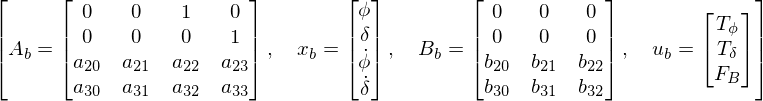

In [4]:
[Eq(MatrixSymbol('{}_b'.format(v), *b[v].shape), b[v]) for v in ['A', 'x', 'B', 'u']]

The second order neuromuscular model can be put in this state space form:

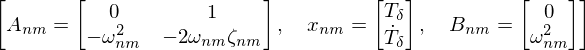

In [5]:
[Eq(MatrixSymbol('{}_nm'.format(v), *n[v].shape), n[v]) for v in ['A', 'x', 'B']]

The closed loop state equations for the first loop closed around the combine neuromuscular and bicycle model is:

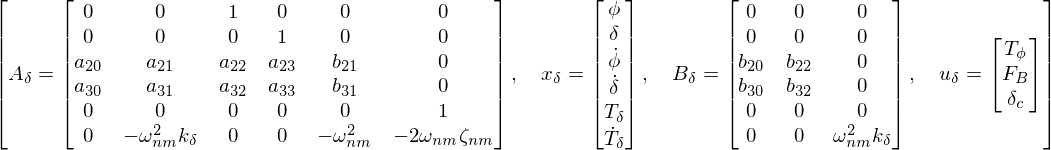

In [6]:
[Eq(MatrixSymbol('{}_\delta'.format(v), *c_delta[v].shape), c_delta[v]) for v in ['A', 'x', 'B', 'u']]

The closed loop state equations for the second closed loop are:

In [7]:
[Eq(MatrixSymbol('{}_\dot{{\phi}}'.format(v), *c_phidot[v].shape), c_phidot[v]) for v in ['A', 'x', 'B', 'u']]

⎡A_\dot{\phi} = ⎡ 0             0                               1             
⎢               ⎢                                                             
⎢               ⎢ 0             0                               0             
⎢               ⎢                                                             
⎢               ⎢a₂₀           a₂₁                             a₂₂            
⎢               ⎢                                                             
⎢               ⎢a₃₀           a₃₁                             a₃₂            
⎢               ⎢                                                             
⎢               ⎢ 0             0                               0             
⎢               ⎢                                                             
⎢               ⎢                 2                       2                   
⎣               ⎣ 0   -\omega_{nm} ⋅k_\delta  -\omega_{nm} ⋅k_\delta⋅k_{\dot{\

        0         0                    0           

# Characteristic Equation

The characteristic equations for each closed loop can be formed for this closed loop system and converted to a polynomial.

In [8]:
s = Symbol('s')

In [9]:
char_eq_delta = det(c_delta['A'] - s * eye(c_delta['A'].shape[0])).as_poly(s)

In [10]:
char_eq_phidot = det(c_phidot['A'] - s * eye(c_phidot['A'].shape[0])).as_poly(s)

The coeffcients of the sixth order polynomials for each characteristic equation are:

In [11]:
for i, coeff in enumerate(char_eq_delta.coeffs()):
    display(Math(r'$s^{}: {}$'.format(len(char_eq_delta.coeffs()) - i - 1, latex(simplify(coeff)))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [12]:
for i, coeff in enumerate(char_eq_phidot.coeffs()):
    display(Math(r'$s^{}: {}$'.format(len(char_eq_phidot.coeffs()) - i - 1, latex(simplify(coeff)))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Solve for the gains

There are two control gains, $k_\delta$ and $k_{\dot{\phi}}$, that are the primary unknowns. We'd like to find the value of the two gains such that the weave poles translate desired locations in the imaginary plane through the first two loop closures. The constraint that we will impose is that these poles should have a specified damping ratio for each of the closed loops, $\zeta_\delta, \zeta_\dot{\phi}$. In the process of solving for the gains, we will also solve for the natural frequency of the closed loop poles in each loop, $\omega_\delta, \omega_\dot{\phi}$.

In [13]:
omega_delta, zeta_delta = symbols('\omega_\delta, \zeta_\delta', real=True, positive=True)
omega_phidot, zeta_phidot = symbols('\omega_\dot{\phi}, \zeta_\dot{\phi}', real=True, positive=True)

In each of the closed looped systems we should find the pairs of poles that fit the following description: 

In [14]:
desired_second_order_delta = Poly((s**2 + 2 * zeta_delta * omega_delta * s + omega_delta**2), s)
desired_second_order_delta

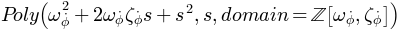

In [15]:
desired_second_order_phidot = Poly((s**2 + 2 * zeta_phidot * omega_phidot * s + omega_phidot**2), s)
desired_second_order_phidot

This pair of poles must be accompanied by four more poles to equate to the sixth order system described in the closed loop systems defined above. The desired sixth order systems with eight additional arbitrary coefficients are then:

In [16]:
c0, c1, c2, c3, c4, c5, c6, c7 = symbols('c0, c1, c2, c3, c4, c5, c6, c7')
desired_six_order_delta = Poly(s**4 + c3 * s**3 + c2 * s**2 + c1 * s + c0, s) * desired_second_order_delta
desired_six_order_delta

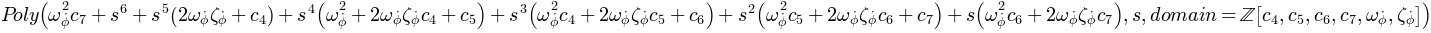

In [17]:
desired_six_order_phidot = Poly(s**4 + c4 * s**3 + c5 * s**2 + c6 * s + c7, s) * desired_second_order_phidot
desired_six_order_phidot

The coefficients of the desired polynomial and the one formed from the closed loop system can then be substracted from each other to solve for the unknowns: $c_0, c_1, c_2, c_3, c_4, c_5, c_6, c_7, k_\delta, k_{\dot{\phi}}, \omega_\delta, \omega_\dot{\phi}$. This gives 12 nolinear equations in 12 unknowns.

In [18]:
zero_delta = Matrix((char_eq_delta - desired_six_order_delta).coeffs())

In [19]:
zero_phidot = Matrix((char_eq_phidot - desired_six_order_phidot).coeffs())

In [20]:
zero_all = zero_delta.col_join(zero_phidot)
zero_all

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                    2        
⎢                                                     - \omega_\delta ⋅c₂ - 2⋅
⎢                                                                             
⎢                                                                             
⎢                                                   

The following loads in the numerical parameters for the benchmark bicycle traveling at 5 m/s, for futher use.

In [21]:
A_benchmark, B_benchmark = bicycle.benchmark_state_space(*bicycle.benchmark_matrices(), 5.0, 9.81)

In [22]:
A_benchmark, B_benchmark

(array([[  0.        ,   0.        ,   1.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   1.        ],
        [  9.48977445, -22.85146663,  -0.52761225,  -1.65257699],
        [ 11.71947687, -18.38412373,  18.38402617, -15.42432764]]),
 array([[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.01593498, -0.12409203],
        [-0.12409203,  4.32384018]]))

Create a dictionary of the known parameters that can be used to substitute the numerical values for the benchmark bicycle.

In [23]:
par = {k: v for k, v in zip(b['A'], A_benchmark.flatten()) if isinstance(k, Symbol)}
par[omega] = 30
par[zeta] = 0.707
par[zeta_delta] = 0.15
par[zeta_phidot] = 0.1
par[b['B'][2, 1]] = B_benchmark[2, 1]
par[b['B'][3, 1]] = B_benchmark[3, 1]
par

The following shows the form of the twelve equations that must be solved to find the gains, the frequencies, and the other coefficients.

In [24]:
zero_all.subs(par)

⎡                                                   -0.3⋅\omega_\delta - c₃ + 
⎢                                                                             
⎢                                                        2                    
⎢                                         - \omega_\delta  - 0.3⋅\omega_\delta
⎢                                                                             
⎢                                                       2                     
⎢                                        - \omega_\delta ⋅c₃ - 0.3⋅\omega_\del
⎢                                                                             
⎢                                        2                                    
⎢                         - \omega_\delta ⋅c₂ - 0.3⋅\omega_\delta⋅c₁ - c₀ + 38
⎢                                                                             
⎢                                         2                                   
⎢                          - \omega_\delta ⋅c₁ - 0.3

The Jacobian wrt to the unknowns will also be useful for finding the solution to the set of equations.

In [25]:
unknowns = [c0, c1, c2, c3, c4, c5, c6, c7, k_delta, k_phi_dot, omega_delta, omega_phidot]

In [26]:
jacobian = zero_all.jacobian(unknowns)
jacobian

⎡              0                              0                              0
⎢                                                                             
⎢              0                              0                             -1
⎢                                                                             
⎢                                                                             
⎢              0                             -1                -2⋅\omega_\delt
⎢                                                                             
⎢                                                                             
⎢             -1                -2⋅\omega_\delta⋅\zeta_\delta         -\omega_
⎢                                                                             
⎢                                                    2                        
⎢-2⋅\omega_\delta⋅\zeta_\delta         -\omega_\delta                        0
⎢                                                   

In [27]:
knowns = list(ordered(zero_all.free_symbols.difference(unknowns)))

In [28]:
knowns

In [29]:
from sympy.printing.lambdarepr import lambdarepr
print(lambdarepr(zero_all))

MutableDenseMatrix([[-2*\omega_\delta*\zeta_\delta + 2*\omega_{nm}*\zeta_{nm} - a_22 - a_33 - c3], [-\omega_\delta**2 - 2*\omega_\delta*\zeta_\delta*c3 + \omega_{nm}**2 - 2*\omega_{nm}*\zeta_{nm}*a_22 - 2*\omega_{nm}*\zeta_{nm}*a_33 - a_20 + a_22*a_33 - a_23*a_32 - a_31 - c2], [-\omega_\delta**2*c3 - 2*\omega_\delta*\zeta_\delta*c2 - \omega_{nm}**2*a_22 - \omega_{nm}**2*a_33 - 2*\omega_{nm}*\zeta_{nm}*a_20 + 2*\omega_{nm}*\zeta_{nm}*a_22*a_33 - 2*\omega_{nm}*\zeta_{nm}*a_23*a_32 - 2*\omega_{nm}*\zeta_{nm}*a_31 + a_20*a_33 - a_21*a_32 + a_22*a_31 - a_23*a_30 - c1], [-\omega_\delta**2*c2 - 2*\omega_\delta*\zeta_\delta*c1 - \omega_{nm}**2*a_20 + \omega_{nm}**2*a_22*a_33 - \omega_{nm}**2*a_23*a_32 - \omega_{nm}**2*a_31 + \omega_{nm}**2*b_31*k_\delta + 2*\omega_{nm}*\zeta_{nm}*a_20*a_33 - 2*\omega_{nm}*\zeta_{nm}*a_21*a_32 + 2*\omega_{nm}*\zeta_{nm}*a_22*a_31 - 2*\omega_{nm}*\zeta_{nm}*a_23*a_30 + a_20*a_31 - a_21*a_30 - c0], [-\omega_\delta**2*c1 - 2*\omega_\delta*\zeta_\delta*c0 + \omega_

Now, two numerical functions that evaluate the equations and its Jacobian can be created.

In [30]:
f_zero = lambdify(unknowns + knowns, zero_all)

In [31]:
f_jac_zero = lambdify(unknowns + knowns, jacobian)

In [32]:
f_zero(*np.random.random(len(unknowns + knowns)))

array([[-1.84765844],
       [-2.61857305],
       [-0.43179863],
       [-0.88098273],
       [-0.3669605 ],
       [-0.09742701],
       [-2.02564766],
       [-2.98335775],
       [-0.12913183],
       [-0.74780759],
       [-0.09327239],
       [-0.4550624 ]])

In [33]:
f_jac_zero(*np.random.random(len(unknowns + knowns)))

array([[ 0.        ,  0.        ,  0.        , -1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.46803676,  0.        ],
       [ 0.        ,  0.        , -1.        , -0.06096901,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.30079785,  0.        ],
       [ 0.        , -1.        , -0.06096901, -0.01696908,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.18784355,  0.        ],
       [-1.        , -0.06096901, -0.01696908,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.31132162,  0.        ,
        -0.54950381,  0.        ],
       [-0.06096901, -0.01696908,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.10884181,  0.        ,
        -0.71106939,  0.        ],
       [-0.01696908,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  

Here we create a wrapper for the functions that allow us to pass in the variables in a more convenient form.

In [34]:
def fsolve_zero(unknowns, A, B, omega_nm, zeta_delta, zeta_phidot, zeta_nm):
    args = np.hstack((unknowns, omega_nm, zeta_delta, zeta_phidot, zeta_nm, A[2:, :].flatten(), B[2:, 1].flatten()))
    return f_zero(*args).squeeze()           

In [35]:
def fsolve_jac_zero(unknowns, A, B, omega_nm, zeta_delta, zeta_phidot, zeta_nm):
    args = np.hstack((unknowns, omega_nm, zeta_delta, zeta_phidot, zeta_nm, A[2:, :].flatten(), B[2:, 1].flatten()))
    return f_jac_zero(*args).squeeze()           

At this point, `fsolve` can be used to find the solution starting with a guess.

In [36]:
guess = np.hstack((np.random.random(8), 45.0, -0.05, 14.0, 14.0))

In [37]:
res = fsolve(fsolve_zero, guess, args=(A_benchmark, B_benchmark, 30, 0.1289, 0.0855, 0.707), fprime=fsolve_jac_zero)

In [38]:
res

array([ -8.71798244e+03,   1.58227411e+03,   1.23258658e+03,
         5.47761600e+01,   5.59477325e+01,   1.28748836e+03,
         2.57663234e+03,  -8.43896177e+03,   4.65520391e+01,
        -5.21602768e-02,   1.39479436e+01,   1.41766516e+01])

In [39]:
fsolve_zero(res, A_benchmark, B_benchmark, 30, 0.1289, 0.0855, 0.707)

array([  7.10542736e-15,   1.58638613e-09,   4.83598797e-08,
        -2.57489097e-06,  -1.18671945e-04,   9.37446021e-05,
         0.00000000e+00,  -4.86579665e-10,  -3.40160113e-08,
         2.17042179e-06,   1.80584323e-04,  -5.17540611e-05])

In [40]:
sol = {k: v for k, v in zip(unknowns, res)}
sol

# Generate a Matlab function

In [41]:
m_func_template = '''\
function [k_delta, k_phi_dot] = compute_inner_gains(A, B, omega_nm, zeta_nm, zeta_delta, zeta_phidot)
% function [k_delta, k_phi_dot] = compute_inner_gains(A, B, omega_nm, zeta_nm, zeta_delta, zeta_phidot)
% Returns the steer and roll rate gains given the state and input
% matrices of the bicycle, the neuromuscular block's natural
% frequency and damping ratio, and the desired closed loop damping
% ratio of the signature neuromuscular peak in each of the closed loops.
%
%   Parameters
%   ==========
%
%   A : double, size 11 x 11
%       The state matrix for a linear Whipple bicycle model, where
%       the 4th, 7th, 9th, and 11th states are [roll angle, steer angle, roll angular rate,
%       steer angular rate].
%   B : double, size 11 x 3
%       The input matrix for a linear Whipple bicycle model, where
%       the 2nd input is [steer torque].
%   omega_nm : double, size 1 x 1
%       The natural frequency of the neuromuscular model.
%   zeta_nm : double, size 1 x 1
%       The damping ratio of the neuromuscular model.
%   zeta_delta : double, size 1 x 1
%       The damping ratio of the desired closed loop pole.
%   zeta_phidot : double, size 1 x 1
%       The damping ratio of the desired closed loop pole.
%
%   Returns
%   =======
%   k_delta : float
%       The steer angle feedback gain.
%   k_phi_dot : float
%       The roll rate feedback gain.

    knowns = [omega_nm, zeta_delta, zeta_phidot, zeta_nm, reshape(A([9, 11], [4, 7, 9, 11]).', 1, []), reshape(B([9, 11], 2).', 1, [])];

    func = @(unknowns) eval_func(unknowns, knowns);

    % TODO : This guess comes from the known solution for the Benchmark bike
    % at 5 m/s, this should be made more robust.
    guess = [-8.71798244e3, 1.58227411e3, 1.23258658e3, 5.47761600e1, 5.59477325e1, 1.28748836e3, 2.57663234e3, -8.43896178e3, 4.65520391e1, -5.21602768e-2, 1.39479436e1, 1.41766516e1];

    options = optimoptions(@fsolve, 'Jacobian', 'on'); % Note that this is different in newer matlab versions.
    sol = fsolve(func, guess, options);

    k_delta = sol(9);
    k_phi_dot = sol(10);

function sexprs = eval_sub_exprs(unknowns, knowns, sexprs)

    {unknowns_knowns_expansion}

    {sub_exprs}

function [zero, zero_jac] = eval_func(unknowns, knowns)

    {unknowns_knowns_expansion}

    sexprs = zeros({num_sub_exprs});
    sexprs = eval_sub_exprs(unknowns, knowns, sexprs);

    {zero}
    
    if nargout > 1
    
        {zero_jac}
    
    end
'''

In [42]:
def matlab_vector():
    start = 1
    while True:
        name = 'sexprs({})'.format(start)
        s = Symbol(name)
        yield s
        start += 1

In [43]:
sub_exprs, main_exprs = cse((zero_all, jacobian), symbols=matlab_vector())

In [44]:
sub_exprs_txt = [re.sub(r'sexprs_(\d*)_', r'sexprs(\1)', octave_code(y, assign_to=x)) for x, y in sub_exprs]

In [45]:
main_exprs_txt = [re.sub(r'sexprs_(\d*)_', r'sexprs(\1)', octave_code(expr, assign_to=var))
                  for var, expr in zip(['zero', 'zero_jac'], main_exprs)]

In [46]:
expand_unknowns_knowns = ([octave_code(Symbol('unknowns({})'.format(i + 1)), assign_to=s) for i, s in enumerate(unknowns)] +
 [octave_code(Symbol('knowns({})'.format(i + 1)), assign_to=s) for i, s in enumerate(knowns)])
expand_unknowns_knowns = [re.sub(r'knowns_(\d*)_', r'knowns(\1)', t) for t in expand_unknowns_knowns]

In [47]:
m_func_txt = m_func_template.format(
                                    sub_exprs='\n    '.join(sub_exprs_txt),
                                    num_sub_exprs=len(sub_exprs_txt),
                                    unknowns_knowns_expansion='\n    '.join(expand_unknowns_knowns),
                                    zero=main_exprs_txt[0],
                                    zero_jac=main_exprs_txt[1])
print(m_func_txt)

function [k_delta, k_phi_dot] = compute_inner_gains(A, B, omega_nm, zeta_nm, zeta_delta, zeta_phidot)
% function [k_delta, k_phi_dot] = compute_inner_gains(A, B, omega_nm, zeta_nm, zeta_delta, zeta_phidot)
% Returns the steer and roll rate gains given the state and input
% matrices of the bicycle, the neuromuscular block's natural
% frequency and damping ratio, and the desired closed loop damping
% ratio of the signature neuromuscular peak in each of the closed loops.
%
%   Parameters
%   ==========
%
%   A : double, size 11 x 11
%       The state matrix for a linear Whipple bicycle model, where
%       the 4th, 7th, 9th, and 11th states are [roll angle, steer angle, roll angular rate,
%       steer angular rate].
%   B : double, size 11 x 3
%       The input matrix for a linear Whipple bicycle model, where
%       the 2nd input is [steer torque].
%   omega_nm : double, size 1 x 1
%       The natural frequency of the neuromuscular model.
%   zeta_nm : double, size 1 x 1
%       The dam

In [48]:
with open('../src/compute_inner_gains.m', 'w') as f:
    f.write(m_func_txt)

# Generate a Python Function

In [49]:
py_func_template = '''\
def compute_inner_gains(A, B, omega_nm, zeta_nm, zeta_delta, zeta_phidot):
    """Returns the steer and roll rate gains given the state and input matrices
    of the bicycle, the neuromuscular block's natural frequency and damping
    ratio, and the desired closed loop damping ratio of the signature
    neuromuscular peak in each of the closed loops.

    Parameters
    ==========

    A : array_like, shape(4, 4)
        The state matrix for a linear Whipple bicycle model, where states are
        [roll angle, steer angle, roll angular rate, steer angular rate].
    B : array_like, shape(4, 2)
        The input matrix for a linear Whipple bicycle model, where
        the 2nd input is [steer torque].
    omega_nm : float
        The natural frequency of the neuromuscular model.
    zeta_nm : float
        The damping ratio of the neuromuscular model.
    zeta_delta : float
        The damping ratio of the desired closed loop pole.
    zeta_phidot : float
        The damping ratio of the desired closed loop pole.

    Returns
    =======
    k_delta : float
        The steer angle feedback gain.
    k_phi_dot : float
        The roll rate feedback gain.

    """

    knowns = [omega_nm, zeta_delta, zeta_phidot, zeta_nm, reshape(A([9, 11], [4, 7, 9, 11]).', 1, []), reshape(B([9, 11], 2).', 1, [])];

    % TODO : This guess comes from the known solution for the Benchmark bike
    % at 5 m/s, this should be made more robust.
    guess = np.array([-8.71798244e3, 1.58227411e3, 1.23258658e3, 5.47761600e1,
                      5.59477325e1, 1.28748836e3, 2.57663234e3, -8.43896178e3,
                      4.65520391e1, -5.21602768e-2, 1.39479436e1, 1.41766516e1])
    
    sexprs = np.zeros({num_sub_exprs});

    res = fsolve(eval_zero, guess, fprime=eval_jacobian, args=(knowns, sexprs))
    
    k_delta = res(8)
    k_phidot = res(9)

    return k_delta, k_phidot
    

def eval_sub_exprs(unknowns, knowns, sexprs):

    {unknowns_knowns_expansion}

    {sub_exprs}
    
    return sexprs
   
   
def eval_zero(unknowns, knowns, sexprs):

    update_sub_exprs(unknowns, knowns, sexprs)

    {zero}

    return zero
    
    
def eval_jacobian(unknowns, knowns):

    {unknowns_knowns_expansion}

    sexprs = eval_sub_exprs(unknowns, knowns, sexprs);

    {zero_jac}

'''

In [50]:
!conda list

# packages in environment at /home/moorepants/miniconda3/envs/bmd2016:
#
Using Anaconda API: https://api.anaconda.org
cairo                     1.12.18                       6  
uncertainties             2.4.8                    py35_0    conda-forge
cycler                    0.10.0                   py35_0  
decorator                 4.0.10                   py35_0  
dill                      0.2.5                    py35_0  
entrypoints               0.2.2                    py35_0  
fontconfig                2.11.1                        6  
freetype                  2.5.5                         1  
glib                      2.43.0                        1  
harfbuzz                  0.9.39                        1  
ipykernel                 4.3.1                    py35_0  
ipython                   5.0.0                    py35_0  
ipython-notebook          4.0.4                    py35_0  
ipython_genutils          0.1.0                    py35_0  
jinja2                    2.8